### Load Packages

In [1]:
!pip install catboost==0.8.1.1 

     |████████████████████████████████| 33.6MB 1.2MB/s 


In [0]:
# primary EDA code
import pandas as pd
import numpy as np
import os

# packages for plots
import matplotlib.pyplot as plt
import seaborn as sns

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb

# packages for cross-validation
from sklearn.model_selection import KFold

### Load Data & Filter NA/ Duplicate Records

In [3]:
# Read files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def data_import(folder_path, signal_type = "buy"):
    df_gp = pd.DataFrame()
    print()
    print("Loading", signal_type, "singal data:")
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            stock = filename[0:4]
            print(stock, " ", end = '')
            try:
                temp_df = pd.read_csv(os.path.join(folder_path, filename), delimiter= '\s+', header = None)
                temp_df.rename(columns={123:'rtn'}, inplace=True)
                temp_df = temp_df.iloc[21:,:]
                if signal_type == "buy":
                  temp_df = pd.concat([pd.Series([1] * temp_df.shape[0], name = 'signal_type'), temp_df], axis=1)
                else:
                  temp_df = pd.concat([pd.Series([0] * temp_df.shape[0], name = 'signal_type'), temp_df], axis=1)
                  temp_df['rtn'] = -temp_df['rtn']
                df_gp = pd.concat([df_gp, temp_df])
                continue
            except:
                print('The following file cannot be read: ' + folder_path + filename)
        else:
            continue
    
    # Set all columns to numerics
    for col in df_gp.columns:
        df_gp[col] = pd.to_numeric(df_gp[col],errors='coerce')
            
    # Rename the columns
    osc_headers = []
    stk_headers = []
    macd_headers = []
    for i in range(41):
        osc_headers.append('osc' + str(i))
        stk_headers.append('stk' + str(i))
        macd_headers.append('macd' + str(i))
    df_gp.columns = ['signal_type'] + osc_headers + stk_headers + macd_headers + ['rtn']
    
    # Reset index
    df_gp = df_gp.reset_index(drop=True)

    return df_gp

In [5]:
# Import Buy & Sell Data
df_buy_gp = data_import('/content/gdrive/My Drive/capstone/data/buy/', signal_type = "buy")
print()
df_sell_gp = data_import('/content/gdrive/My Drive/capstone/data/sell/', signal_type = "sell")

df_combined = pd.concat([df_buy_gp, df_sell_gp])

# Drop Duplicated Records
len_before = df_combined.shape[0]
df_combined = df_combined.drop_duplicates(subset = df_combined.columns[1:])
print()
print()
print("Duplicates dropped:", len_before - df_combined.shape[0])

# Drop Records with NaN
len_before = df_combined.shape[0]
df_combined = df_combined.dropna()
print()
print("Record(s) w/ NaN dropped:", len_before - df_combined.shape[0])
print()

# Reset Index
df_combined = df_combined.reset_index(drop=True)

print("Remained Records:", df_combined.shape[0])
print()

# Check the balance of df_gp
print('Positive returns:', round(np.sum(df_combined.rtn > 0)/len(df_combined.rtn) * 100, 2), '%')
print('Zero returns:', round(np.sum(df_combined.rtn == 0)/len(df_combined.rtn) * 100, 2), '%')
print('Negative returns:', round(np.sum(df_combined.rtn < 0)/len(df_combined.rtn) * 100, 2), '%')

# Check average stock movement
print('Stock Movement %', np.mean(df_combined.rtn))


Loading buy singal data:
adbe  ions  ssys  ati1  itub  alny  pxd1  ufs1  bac1  uri1  clf1  gs1B  jnpr  crm1  mas1  crus  pru1  bidu  fslr  csiq  jec1  db1B  acad  amd1  cenx  teck  meli  

Loading sell singal data:
csiq  fslr  bidu  lvsS  uriS  masS  pxdS  crmS  crus  pruS  meli  cenx  ufsS  acad  amdS  dbSe  teck  alny  itub  atiS  adsk  ssys  ions  adbe  gsSe  clfS  bacS  

Duplicates dropped: 4579

Record(s) w/ NaN dropped: 1127

Remained Records: 202757

Positive returns: 48.85 %
Zero returns: 3.37 %
Negative returns: 47.78 %
Stock Movement % 0.03338858831014412


### Split Data Into Parts

In [0]:
def data_organize(df_gp):
    try:
        signal_gp = df_gp.iloc[:, 0]
        osc_gp = df_gp.iloc[:, 1:42]
        stk_gp = df_gp.iloc[:, 42:83]
        macd_gp = df_gp.iloc[:, 83:124]
        rtn_gp = df_gp.iloc[:, 124]
        #label_gp = np.sign(rtn_gp).map({1: 1, -1: 0, 0:0})
        label_gp = (rtn_gp > 0).map({False: 0, True: 1})
        results_gp = label_gp.map({1: 'EARN', 0: 'LOSS'})
        for i in range(len(label_gp)):
          if rtn_gp[i] > 3:
            label_gp[i] = 3
          elif rtn_gp[i] < -3:
            label_gp[i] = -3
          elif rtn_gp[i] == 0:
            label_gp[i] = 0
        print('2 :', round(np.sum(label_gp == 2)/len(label_gp) * 100, 2), '%')
        print('1 :', round(np.sum(label_gp == 1)/len(label_gp) * 100, 2), '%')
        print('0 :', round(np.sum(label_gp == 0)/len(label_gp) * 100, 2), '%')
        print('-1:', round(np.sum(label_gp == -1)/len(label_gp) * 100, 2), '%')
        print('-2:', round(np.sum(label_gp == -2)/len(label_gp) * 100, 2), '%')
    except:
        print('Please check the dataframe index')

    return signal_gp, osc_gp, stk_gp, macd_gp, rtn_gp, label_gp, results_gp

In [7]:
# Cut Extras
df_combined_extra, df_combined, waste, waste_label = train_test_split(df_combined, df_combined.iloc[:,0], test_size=0.1)

# Reset Index
df_combined = df_combined.reset_index(drop=True)

print("Remained Records:", df_combined.shape[0])
print()

# Check the balance of df_gp
print('Positive returns:', round(np.sum(df_combined.rtn > 0)/len(df_combined.rtn) * 100, 2), '%')
print('Zero returns:', round(np.sum(df_combined.rtn == 0)/len(df_combined.rtn) * 100, 2), '%')
print('Negative returns:', round(np.sum(df_combined.rtn < 0)/len(df_combined.rtn) * 100, 2), '%')

Remained Records: 20276

Positive returns: 49.4 %
Zero returns: 3.21 %
Negative returns: 47.39 %


In [31]:
signal_gp, osc_gp, stk_gp, macd_gp, rtn_gp, label_gp, results_gp = data_organize(df_combined)

2 : 0.0 %
1 : 44.81 %
0 : 46.06 %
-1: 0.0 %
-2: 0.0 %


### Feature Engineering - add Additional Features

In [0]:
def smooth_generator(data):
    cut_point = int(data.shape[1]/4)
    smooths = pd.DataFrame()
    for k in range(4):
        smooth_list = []  
        for i in range(data.shape[0]):
            data_cut = data.iloc[i,k*cut_point:(k+1)*cut_point]
            avg_amp = np.mean(np.abs(data_cut))
            smooth_list.append(np.var(np.diff(np.diff(data_cut)))/avg_amp)
        smooth = pd.DataFrame(smooth_list, columns=["smooth" + str(k)])
        smooths = pd.concat([smooths, smooth], axis = 1)
    return smooths

def derivative(data, space = 1, name = "d", relative = False):
    dy = []
    for i in range(data.shape[0]):
        y = pd.Series(data.iloc[i,:])
        # Relative change
        if relative == True:
            y = y/(np.mean(np.abs(y)))
        temp_dy = list(np.diff(y))
        #temp_dy = list(np.gradient(y, space))
        dy.append(temp_dy)

    col_name = []
    for i in range(len(temp_dy)):
        col_name.append(name + str(i))

    deriv_df = pd.DataFrame(dy, columns=col_name)

    return deriv_df

def psd_generator(data, NFFT = 100, name = "osc"):
    freq = []
    for i in range(data.shape[0]):
        data_osc = data.iloc[i,:]
        p = Periodogram(data_osc, NFFT=NFFT)
        temp_list = list(p.psd)
        freq.append(temp_list)
    col_name = []
    for i in range(int(NFFT/2)+1):
        col_name.append("psd"+str(i))

    psd_df = pd.DataFrame(freq, columns=col_name)
    return psd_df

def volatility(data):
    cut_point = int(data.shape[1]/4)
    vols = pd.DataFrame()
    for k in range(4):
        vol = []
        for i in range(data.shape[0]):
            vol.append(np.var(data.iloc[i,k*cut_point:(k+1)*cut_point]))
        vol = pd.DataFrame(vol, columns=["volatility" + str(k)])
        vols = pd.concat([vols, vol], axis = 1)
    return vols
  
def last_signal(data):
    last_signal_df = pd.DataFrame()
    last_signal_len = []
    last_signal_type = []
    
    for i in range(data.shape[0]):
        y = pd.Series(data.iloc[i,:])
        dy = list(np.diff(y))
        dy_sign = np.sign(dy)
        
        last_type = 0
        j = len(dy_sign) - 1
        
        for j in range(1, len(dy_sign) - 1):
          if dy_sign[j + 1] != dy_sign[j] and dy_sign[j + 1] != 0:
            last_time = j
            last_type = dy_sign[j + 1]
            break
        
        last_signal_len.append(last_time)
        last_signal_type.append(last_type)
            
    col_name = ['last_s_len','last_s_type']
    
    last_signal_df = pd.DataFrame(pd.concat([pd.Series(last_signal_len),pd.Series(last_signal_type)], axis=1))
    last_signal_df.columns = col_name
    
    return last_signal_df

In [0]:
# calculate the dy for macd
first_deriv_macd = derivative(macd_gp, name="d_macd", relative = True)    

# calculate the ddy for macd
second_deriv_macd = derivative(first_deriv_macd, name="dd_macd", relative = False) 

In [0]:
# calculate the dy for osc
first_deriv_osc = derivative(osc_gp, name="d_osc", relative = True)

# calculate the ddy for osc
second_deriv_osc = derivative(first_deriv_osc, name="dd_osc", relative = False) 

# calculate the smooth for osc
smooth_osc = smooth_generator(osc_gp)

In [0]:
# calculate the dy for stock
first_deriv_stk = derivative(stk_gp, name="d_stk", relative = True)

# calculate the ddy for stock
second_deriv_stk = derivative(first_deriv_stk, name="dd_stk", relative = False)

# calculate the volatility for stock
vol_stk = volatility(stk_gp)

In [0]:
# info on last signal
last_signal = last_signal(osc_gp)

### Combine Features

In [0]:
Feature_matrix_w_rtn = pd.concat([rtn_gp, signal_gp, last_signal, smooth_osc, first_deriv_macd, second_deriv_macd, first_deriv_osc, second_deriv_osc, first_deriv_stk, second_deriv_stk, vol_stk, osc_gp, macd_gp], axis=1)


### LGBM + 5 fold CV


In [0]:
results_summaries_collection = pd.DataFrame()
results_summaries_collection_tc = pd.DataFrame()

# n-fold Cross Validation
kf = KFold(n_splits=5, shuffle = True)
kf.get_n_splits(Feature_matrix_w_rtn)

# Within each fold
for train_index, test_index in kf.split(Feature_matrix_w_rtn):

    # Define train/ validation set (convert X_w_rtn and y to np.array for indexing on the next line)
    X_train_w_rtn, X_valid_w_rtn = Feature_matrix_w_rtn.values[train_index], Feature_matrix_w_rtn.values[test_index]
    y_train, y_valid = label_gp.values[train_index], label_gp.values[test_index]
    
    # Separate returns from Feature matrix (convert X_w_rtn and y back to pandas)
    X_train = pd.DataFrame(X_train_w_rtn).iloc[:, 1:]
    X_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 1:]

    rtn_train = pd.DataFrame(X_train_w_rtn).iloc[:, 0]
    rtn_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 0]
    
    y_train = pd.Series(y_train)
    y_valid = pd.Series(y_valid)
    
    # Reset indices on all
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    rtn_train = rtn_train.reset_index(drop=True)
    
    X_valid = X_valid.reset_index(drop=True)
    y_valid = y_valid.reset_index(drop=True)
    rtn_valid = rtn_valid.reset_index(drop=True)
    
    # Train Model
    lg = lgb.LGBMClassifier(silent=False)
    data_train = lgb.Dataset(X_train, label=y_train)
    params = {"max_depth": 50, "learning_rate" : 0.01, "num_leaves": 300,  "n_estimators": 200}
    
    model2 = lgb.train(params, data_train)
    #model2 = lgb.train(data_train)
    
    # Extracts the probabilities of being a good trade
    proba_set_valid = model2.predict(X_valid)
    proba_valid = []
    for prob in range(len(proba_set_valid)):
        proba_valid.append(proba_set_valid[prob])
    
    # Classify the Classes of the Trades
    threshold_90 = np.percentile(proba_valid, 90)
    threshold_80 = np.percentile(proba_valid, 80)
    threshold_70 = np.percentile(proba_valid, 70)
    threshold_60 = np.percentile(proba_valid, 60)
    threshold_50 = np.percentile(proba_valid, 50)
    threshold_40 = np.percentile(proba_valid, 40)
    threshold_30 = np.percentile(proba_valid, 30)
    threshold_20 = np.percentile(proba_valid, 20)
    threshold_10 = np.percentile(proba_valid, 10)
    
    trade_classes = ['0'] * len(proba_valid)
    for i in range(len(proba_valid)):
      if proba_valid[i] > threshold_90:
        trade_classes[i] = '9'
      elif proba_valid[i] > threshold_80:
        trade_classes[i] = '8'
      elif proba_valid[i] > threshold_70:
        trade_classes[i] = '7'
      elif proba_valid[i] > threshold_60:
        trade_classes[i] = '6'
      elif proba_valid[i] > threshold_50:
        trade_classes[i] = '5'
      elif proba_valid[i] > threshold_40:
        trade_classes[i] = '4'
      elif proba_valid[i] > threshold_30:
        trade_classes[i] = '3'
      elif proba_valid[i] > threshold_20:
        trade_classes[i] = '2'
      elif proba_valid[i] > threshold_10:
        trade_classes[i] = '1'
        
    # Put Results Together
    results = pd.concat([pd.DataFrame(proba_valid), pd.DataFrame(trade_classes), y_valid, rtn_valid], axis =1)
    results.columns = ['prob', 'trade_class', 'label', 'return']
    results['label'] = results['label'] > 0
    results['prob'] = np.round(results['prob'],1)
    
    # Make Results Summary
    results_summary = pd.concat([results.groupby(['prob']).mean()['label'], results.groupby(['prob']).count()['label'], results.groupby(['prob']).mean()['return']],axis=1)
    results_summary.columns = ['StkUpRate', 'Count', 'Stk Mvt%']
    #results_summary['% of All Trades'] = np.round(results_summary['Count']/np.sum(results_summary['Count']),4)*100
    #results_summary = results_summary[results_summary.Count > 5]
    
    # Make Results Summary(TC)
    results_summary_tc = pd.concat([results.groupby(['trade_class']).mean()['label'], results.groupby(['trade_class']).count()['label'], results.groupby(['trade_class']).mean()['return']],axis=1)
    results_summary_tc.columns = ['StkUpRate', 'Count', 'Stk Mvt%']
    #results_summary_tc['% of All Trades'] = np.round(results_summary_tc['Count']/np.sum(results_summary_tc['Count']),4)*100
    #results_summary_tc = results_summary_tc[results_summary_tc.Count > 5]
 
    # Store it in the Results Collection
    results_summaries_collection = pd.concat([results_summaries_collection, results_summary])
    
    # Store it in the Results Collection
    results_summaries_collection_tc = pd.concat([results_summaries_collection_tc, results_summary_tc])

In [37]:
results_summaries_collection_tc.groupby(['trade_class']).mean()

,StkUpRate,Count,Stk Mvt%
trade_class,,,
0,0.469458,406.0,0.046665
1,0.470387,405.2,0.029350
2,0.481030,405.8,0.048821
3,0.453103,405.2,-0.051287
4,0.486932,405.8,0.096670
5,0.489149,405.2,0.021187
6,0.499753,405.0,-0.009881
7,0.521675,406.0,0.058557
8,0.532346,405.0,0.003891


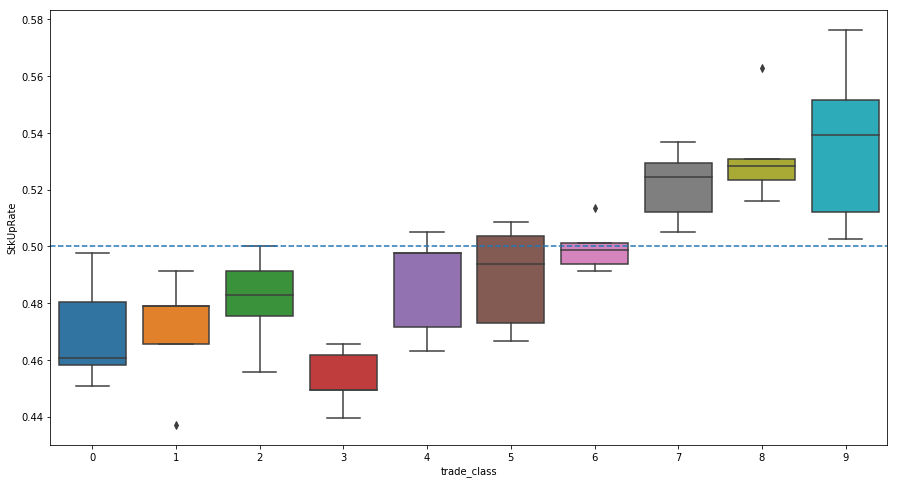

In [38]:
plt.figure(figsize=(15,8))
df_plot = results_summaries_collection_tc.reset_index()
ax = sns.boxplot(y=df_plot["StkUpRate"], x=df_plot["trade_class"])
ax.axhline(0.5, ls='--')

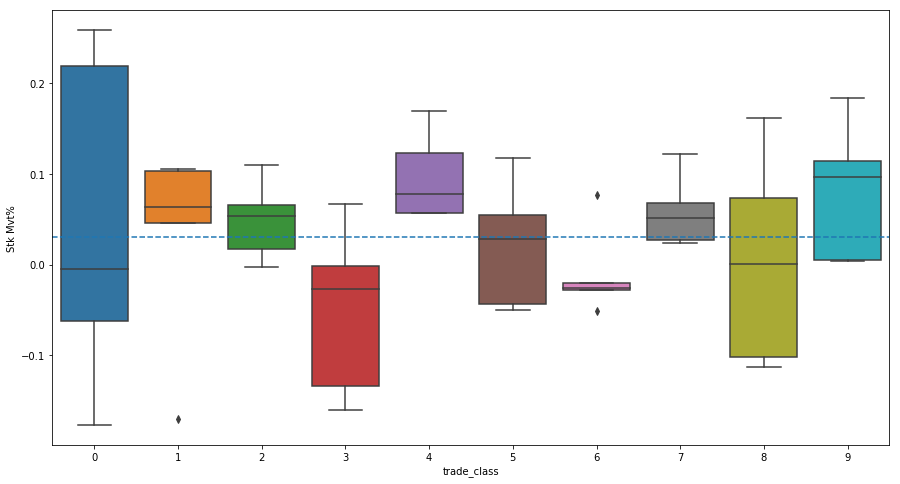

In [39]:
plt.figure(figsize=(15,8))
df_plot = results_summaries_collection_tc.reset_index()
ax = sns.boxplot(y=df_plot["Stk Mvt%"], x=df_plot["trade_class"])
ax.axhline(0.03, ls='--')

### CatBoost

In [19]:
results_summaries_collection = pd.DataFrame()
results_summaries_collection_tc = pd.DataFrame()

# n-fold Cross Validation
kf = KFold(n_splits=20, shuffle = True)
kf.get_n_splits(Feature_matrix_w_rtn)

# Within each fold
for train_index, test_index in kf.split(Feature_matrix_w_rtn):

    # Define train/ validation set (convert X_w_rtn and y to np.array for indexing on the next line)
    X_train_w_rtn, X_valid_w_rtn = Feature_matrix_w_rtn.values[train_index], Feature_matrix_w_rtn.values[test_index]
    y_train, y_valid = label_gp.values[train_index], label_gp.values[test_index]
    
    # Separate returns from Feature matrix (convert X_w_rtn and y back to pandas)
    X_train = pd.DataFrame(X_train_w_rtn).iloc[:, 1:]
    X_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 1:]

    rtn_train = pd.DataFrame(X_train_w_rtn).iloc[:, 0]
    rtn_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 0]
    
    y_train = pd.Series(y_train)
    y_valid = pd.Series(y_valid)
    
    # Reset indices on all
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    rtn_train = rtn_train.reset_index(drop=True)
    
    X_valid = X_valid.reset_index(drop=True)
    y_valid = y_valid.reset_index(drop=True)
    rtn_valid = rtn_valid.reset_index(drop=True)
    
    # Train Model
    clf = cb.CatBoostClassifier(eval_metric="Precision", depth=10, iterations= 10, l2_leaf_reg= 9, learning_rate= 0.15, verbose =190)
    clf.fit(X_train,y_train)
    
    # Extracts the probabilities of being a good trade
    proba_set_valid = clf.predict_proba(X_valid)
    proba_valid = []
    for prob in range(len(proba_set_valid)):
        proba_valid.append(proba_set_valid[prob][1])
    
    # Classify the Classes of the Trades
    threshold_90 = np.percentile(proba_valid, 90)
    threshold_80 = np.percentile(proba_valid, 80)
    threshold_70 = np.percentile(proba_valid, 70)
    threshold_60 = np.percentile(proba_valid, 60)
    threshold_50 = np.percentile(proba_valid, 50)
    threshold_40 = np.percentile(proba_valid, 40)
    threshold_30 = np.percentile(proba_valid, 30)
    threshold_20 = np.percentile(proba_valid, 20)
    threshold_10 = np.percentile(proba_valid, 10)

    trade_classes = ['0'] * len(proba_valid)
    for i in range(len(proba_valid)):
      if proba_valid[i] > threshold_90:
        trade_classes[i] = '9'
      elif proba_valid[i] > threshold_80:
        trade_classes[i] = '8'
      elif proba_valid[i] > threshold_70:
        trade_classes[i] = '7'
      elif proba_valid[i] > threshold_60:
        trade_classes[i] = '6'
      elif proba_valid[i] > threshold_50:
        trade_classes[i] = '5'
      elif proba_valid[i] > threshold_40:
        trade_classes[i] = '4'
      elif proba_valid[i] > threshold_30:
        trade_classes[i] = '3'
      elif proba_valid[i] > threshold_20:
        trade_classes[i] = '2'
      elif proba_valid[i] > threshold_10:
        trade_classes[i] = '1'

    # Put Results Together
    results = pd.concat([pd.DataFrame(proba_valid), pd.DataFrame(trade_classes), y_valid, rtn_valid], axis =1)
    results.columns = ['prob', 'class', 'label', 'return']
    results['prob'] = np.round(results['prob'],1)


    
    # Make Results Summary
    results_summary = pd.concat([results.groupby(['prob']).mean()['label'], results.groupby(['prob']).count()['label'], results.groupby(['prob']).mean()['return']],axis=1)
    results_summary.columns = ['StkUpRate', 'Count', 'Stk Mvt%']
    #results_summary['% of All Trades'] = np.round(results_summary['Count']/np.sum(results_summary['Count']),4)*100
    #results_summary = results_summary[results_summary.Count > 5]
    
    # Make Results Summary TC
    results_summary_tc = pd.concat([results.groupby(['class']).mean()['label'], results.groupby(['class']).count()['label'], results.groupby(['class']).mean()['return']],axis=1)
    results_summary_tc.columns = ['StkUpRate', 'Count', 'Stk Mvt%']
    
    # Store it in the Results Collection
    results_summaries_collection = pd.concat([results_summaries_collection, results_summary])
    results_summaries_collection_tc = pd.concat([results_summaries_collection_tc, results_summary_tc])
    


0:	learn: 0.5806852	total: 1.98s	remaining: 17.9s
0:	learn: 0.5801265	total: 1.82s	remaining: 16.4s
0:	learn: 0.5797511	total: 2.46s	remaining: 22.1s
0:	learn: 0.5780751	total: 1.94s	remaining: 17.5s


KeyboardInterrupt: ignored

In [0]:
results_summaries_collection.groupby(['prob']).mean()

In [0]:
results_summaries_collection_tc.groupby(['class']).mean()

In [0]:
plt.figure(figsize=(15,8))
df_plot = results_summaries_collection_tc.reset_index()
ax = sns.boxplot(y=df_plot["StkUpRate"], x=df_plot["class"])
ax.axhline(0.5, ls='--')

In [0]:
plt.figure(figsize=(15,8))
df_plot = results_summaries_collection_tc.reset_index()
ax = sns.boxplot(y=df_plot["Stk Mvt%"], x=df_plot["class"])
ax.axhline(0, ls='--')

In [0]:
# Define train/ validation set (convert X_w_rtn and y to np.array for indexing on the next line)
X_train_w_rtn, X_valid_w_rtn, y_train, y_valid = train_test_split(Feature_matrix_w_rtn, label_gp, test_size=0.2)
    
# Separate returns from Feature matrix (convert X_w_rtn and y back to pandas)
X_train = pd.DataFrame(X_train_w_rtn).iloc[:, 1:]
X_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 1:]

rtn_train = pd.DataFrame(X_train_w_rtn).iloc[:, 0]
rtn_valid = pd.DataFrame(X_valid_w_rtn).iloc[:, 0]
    
y_train = pd.Series(y_train)
y_valid = pd.Series(y_valid)
    
# Reset indices on all
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
rtn_train = rtn_train.reset_index(drop=True)
    
X_valid = X_valid.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
rtn_valid = rtn_valid.reset_index(drop=True)
    
# Train Model
clf = cb.CatBoostClassifier(eval_metric="Precision", depth=10, iterations= 200, l2_leaf_reg= 9, learning_rate= 0.15, verbose =50)
clf.fit(X_train,y_train)
    
# Extracts the probabilities of being a good trade
proba_set_valid = clf.predict_proba(X_valid)
proba_valid = []
for prob in range(len(proba_set_valid)):
    proba_valid.append(proba_set_valid[prob][1])

# Classify the Classes of the Trades
threshold_90 = np.percentile(proba_valid, 90)
threshold_80 = np.percentile(proba_valid, 80)
threshold_70 = np.percentile(proba_valid, 70)
threshold_60 = np.percentile(proba_valid, 60)
threshold_50 = np.percentile(proba_valid, 50)
threshold_40 = np.percentile(proba_valid, 40)
threshold_30 = np.percentile(proba_valid, 30)
threshold_20 = np.percentile(proba_valid, 20)
threshold_10 = np.percentile(proba_valid, 10)
    
trade_classes = ['0'] * len(proba_valid)
for i in range(len(proba_valid)):
  if proba_valid[i] > threshold_90:
    trade_classes[i] = '9'
  elif proba_valid[i] > threshold_80:
    trade_classes[i] = '8'
  elif proba_valid[i] > threshold_70:
    trade_classes[i] = '7'
  elif proba_valid[i] > threshold_60:
    trade_classes[i] = '6'
  elif proba_valid[i] > threshold_50:
    trade_classes[i] = '5'
  elif proba_valid[i] > threshold_40:
    trade_classes[i] = '4'
  elif proba_valid[i] > threshold_30:
    trade_classes[i] = '3'
  elif proba_valid[i] > threshold_20:
    trade_classes[i] = '2'
  elif proba_valid[i] > threshold_10:
    trade_classes[i] = '1'

# Put Results Together
results = pd.concat([pd.DataFrame(proba_valid), pd.DataFrame(trade_classes), y_valid, rtn_valid], axis =1)
results.columns = ['prob', 'class', 'label', 'return']
results['prob'] = np.round(results['prob'],1)

# Make Results Summary
results_summary = pd.concat([results.groupby(['prob']).mean()['label'], results.groupby(['prob']).count()['label'], results.groupby(['prob']).mean()['return']],axis=1)
results_summary.columns = ['StkUpRate', 'Count', 'Stk Mvt%']
    
results_summary

In [0]:
# Classify the Classes of the Trades
    threshold_90 = np.percentile(proba_valid, 90)
    threshold_80 = np.percentile(proba_valid, 80)
    threshold_70 = np.percentile(proba_valid, 70)
    threshold_60 = np.percentile(proba_valid, 60)
    threshold_50 = np.percentile(proba_valid, 50)
    threshold_40 = np.percentile(proba_valid, 40)
    threshold_30 = np.percentile(proba_valid, 30)
    threshold_20 = np.percentile(proba_valid, 20)
    threshold_10 = np.percentile(proba_valid, 10)
    
    trade_classes = ['0'] * len(proba_valid)
    for i in range(len(proba_valid)):
      if proba_valid[i] > threshold_90:
        trade_classes[i] = '9'
      elif proba_valid[i] > threshold_80:
        trade_classes[i] = '8'
      elif proba_valid[i] < threshold_70:
        trade_classes[i] = '7'
      elif proba_valid[i] < threshold_60:
        trade_classes[i] = '6'
      elif proba_valid[i] > threshold_50:
        trade_classes[i] = '5'
      elif proba_valid[i] < threshold_40:
        trade_classes[i] = '4'
      elif proba_valid[i] < threshold_30:
        trade_classes[i] = '3'
      elif proba_valid[i] < threshold_20:
        trade_classes[i] = '2'
      elif proba_valid[i] < threshold_10:
        trade_classes[i] = '1'
        
# Make Results Summary(TC)
    results_summary_tc = pd.concat([results.groupby(['trade_class']).mean()['label'], results.groupby(['trade_class']).count()['label'], results.groupby(['trade_class']).mean()['return']],axis=1)
    results_summary_tc.columns = ['StkUpRate', 'Count', 'Stk Mvt%']
    #results_summary_tc['% of All Trades'] = np.round(results_summary_tc['Count']/np.sum(results_summary_tc['Count']),4)*100
    #results_summary_tc = results_summary_tc[results_summary_tc.Count > 5]
 
     # Store it in the Results Collection
    results_summaries_collection_tc = pd.concat([results_summaries_collection_tc, results_summary_tc])

In [0]:
prob = pd.DataFrame(proba_valid)
prob[1][prob[1] > 0.85]

In [0]:
X_valid.iloc[22077:22078,:]

In [0]:
X_valid.iloc[30226:30227,:]

In [0]:
len(proba_valid)

In [0]:
upper_cut = np.percentile(proba_valid, 99)
lower_cut = np.percentile(proba_valid, 1)
proba_valid_df = pd.DataFrame(proba_valid)
proba_valid_df = proba_valid_df[proba_valid > lower_cut]

In [0]:
proba_valid_df